# Difftest Results

To generate results:

```
# make programs
$ ./clsmith-mkprograms -H cc1 -n 10000
# list available OpenCL platforms and devices
$ cldrive --clinfo
# run programs on platform ID and device ID
$ ./clsmith-runprograms -H cc1 0 0
```

Connect to results database:

In [1]:
import db
from db import *

hostname = "cc1"
db.init(hostname)

'mysql://cc1:3306/clsmith'

## Overview

In [16]:
import pandas as pd

session = db.make_session()

data = []
data.append(("Programs", session.query(CLSmithProgram).count(),
                         session.query(CLgenProgram).count()))
data.append(("Testbeds", session.query(CLSmithResult.testbed).group_by(CLSmithResult.testbed).count(),
                         session.query(CLgenResult.testbed).group_by(CLgenResult.testbed).count()))
data.append(("Params", session.query(CLSmithParams).count(), 
                       session.query(CLgenParams).count()))
data.append(("Results", session.query(CLSmithResult).count(),
                        session.query(CLgenResult).count()))

pd.DataFrame(data, columns=["", "CLSmith", "CLgen"])

,,CLSmith,CLgen
0,Programs,10001,1000
1,Testbeds,2,2
2,Params,4,3
3,Results,80008,230


### TestBeds

In [3]:
DEVICES = {
    "GeForce GTX 1080": "NVIDIA GTX 1080",
    "Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz": "Intel E5-2620"
}

testbeds = []
for testbed in session.query(Testbed):
    nresult_clsmith = session.query(CLSmithResult).filter(CLSmithResult.testbed == testbed).count()
    nresult_clgen = session.query(CLgenResult).filter(CLgenResult.testbed == testbed).count()
    clsmith_ratio_result = "{:.2%}".format(nresult_clsmith / session.query(CLSmithResult).count())
    clgen_ratio_result = "{:.2%}".format(nresult_clgen / session.query(CLgenResult).count())
    testbeds.append((testbed.id, testbed.host, DEVICES.get(testbed.device, testbed.device),
                     testbed.driver, nresult_clsmith, clsmith_ratio_result,
                     nresult_clgen, clgen_ratio_result))
    
pd.DataFrame(testbeds, columns=[
    "ID", "Host", "Device", "Driver", "#. CLSmith Results", "CLSmith %", "#. CLgen Results", "CLgen %"])

,ID,Host,Device,Driver,#. CLSmith Results,CLSmith %,#. CLgen Results,CLgen %
0,3,Ubuntu 16.04 64bit,NVIDIA GTX 1080,375.39,40004,50.00%,32,31.07%
1,9,Ubuntu 16.04 64bit,Intel E5-2620,1.2.0.25,40004,50.00%,71,68.93%


### CLSmith Parameters

In [4]:
params = []
for param in session.query(CLSmithParams).order_by(
        CLSmithParams.gsize_x, CLSmithParams.gsize_y, CLSmithParams.gsize_z,
        CLSmithParams.lsize_x, CLSmithParams.lsize_y, CLSmithParams.lsize_z,
        CLSmithParams.optimizations):
    nresult_param = session.query(CLSmithResult).filter(CLSmithResult.params_id == param.id).count()
    ratio_result = "{:.2%}".format(nresult_param / session.query(CLSmithResult).count())
    params.append((param.id, param.gsize, param.lsize, param.optimizations_on_off, nresult_param, ratio_result))

pd.DataFrame(params, columns=["ID", "Global size", "Local size", "Optimizations", "#. of Results", "% of Total Results"])

,ID,Global size,Local size,Optimizations,#. of Results,% of Total Results
0,4,"(1, 1, 1)","(1, 1, 1)",off,20002,25.00%
1,3,"(1, 1, 1)","(1, 1, 1)",on,20002,25.00%
2,2,"(128, 16, 1)","(32, 1, 1)",off,20002,25.00%
3,1,"(128, 16, 1)","(32, 1, 1)",on,20002,25.00%


### CLgen Parameters

In [5]:
params = []
for param in session.query(CLgenParams).order_by(
        CLgenParams.size,
        CLgenParams.gsize_x, CLgenParams.gsize_y, CLgenParams.gsize_z,
        CLgenParams.lsize_x, CLgenParams.lsize_y, CLgenParams.lsize_z,
        CLgenParams.generator, CLgenParams.scalar_val, CLgenParams.optimizations):
    nresult_param = session.query(CLgenResult).filter(CLgenResult.params_id == param.id).count()
    ratio_result = "{:.2%}".format(nresult_param / session.query(CLgenResult).count())
    params.append((param.id, param.size, param.generator, param.scalar_val, 
                   param.gsize, param.lsize, param.optimizations_on_off, 
                   nresult_param, ratio_result))

pd.DataFrame(params, columns=[
    "ID", "Size", "Generator", "Scalar Val", "Global size", "Local size", "Optimizations", 
    "#. of Results", "% of Total Results"])

,ID,Size,Generator,Scalar Val,Global size,Local size,Optimizations,#. of Results,% of Total Results
0,11,256,arange,None,"(1, 1, 1)","(1, 1, 1)",off,0,0.00%
1,10,256,arange,None,"(1, 1, 1)","(1, 1, 1)",on,103,100.00%
2,9,4096,arange,None,"(128, 16, 1)","(32, 1, 1)",on,0,0.00%


### CLgen Exit Status

In [6]:
# set outcomes
session.rollback()
def get_outcome(result):
    if result.status == 1:
        prev = None
        for line in reversed(result.stderr.split('\n')):
            if line == "Error found (callback):":
                # Interpret CLSmith error callback messages:
                return prev.split()[0]
            elif line.startswith("Error"):
                # Interpret CLSmith error messages
                return {
                    "Error enqueueing kernel: -6": "CL_OUT_OF_HOST_MEMORY",
                    "Error sending finish command: -36": "CL_INVALID_COMMAND_QUEUE",
                    "Error building program: -11": "CL_BUILD_PROGRAM _FAILURE",
                    "Error creating kernel: -46": "CL_INVALID_KERNEL_NAME",
                    "Error enqueueing kernel: -5": "CL_OUT_OF_RESOURCES",
                }.get(line, line)
            prev = line
        else:
            raise LookupError
    else:
        # Interpret process status codes:
        return {
            -11: "Segmentation Fault",
            -9: "Timeout (60 seconds)",
            0: "Okay",
        }[result.status]

for result in session.query(CLSmithResult):
    result.outcome = get_outcome(result)
session.commit()
print("done.")

done.


In [7]:
import sqlalchemy as sql

outcomes = []
for testbed in session.query(Testbed).all():
    nresult = session.query(CLSmithResult).filter(CLSmithResult.testbed == testbed).count()

    q = session.query(CLSmithResult.outcome, sql.func.count(CLSmithResult.outcome)).filter(
        CLSmithResult.testbed == testbed).group_by(CLSmithResult.outcome).order_by(sql.desc(sql.func.count(CLSmithResult.outcome)))

    for outcome, count in q.all():
        ratio = (count / nresult) * 100
        outcomes.append((DEVICES.get(testbed.device, testbed.device), outcome, count, ratio))

outcomes = pd.DataFrame(outcomes, columns=["Device", "Outcome", "Count", "% of Total Results"])
outcomes

,Device,Outcome,Count,% of Total Results
0,NVIDIA GTX 1080,Okay,32869,82.164284
1,NVIDIA GTX 1080,Timeout (60 seconds),3754,9.384062
2,NVIDIA GTX 1080,CL_BUILD_PROGRAM _FAILURE,2916,7.289271
3,NVIDIA GTX 1080,CL_INVALID_COMMAND_QUEUE,281,0.702430
4,NVIDIA GTX 1080,CL_OUT_OF_HOST_MEMORY,102,0.254975
5,NVIDIA GTX 1080,CL_INVALID_KERNEL_NAME,80,0.199980
6,NVIDIA GTX 1080,CL_INVALID_VALUE,2,0.005000
7,Intel E5-2620,Okay,28626,71.557844
8,Intel E5-2620,CL_BUILD_PROGRAM _FAILURE,6128,15.318468
9,Intel E5-2620,Timeout (60 seconds),3311,8.276672


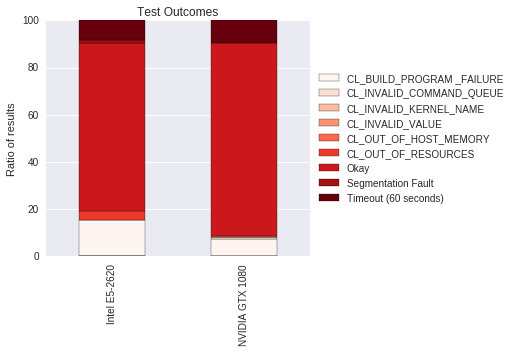

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from labm8 import viz
%matplotlib inline

palette = sns.cubehelix_palette(4, rot=-.4, light=.85, dark=.35)


ax = outcomes.pivot('Device', 'Outcome')['% of Total Results'].plot(kind='bar', stacked=True, colormap='Reds')

plt.title("Test Outcomes")
plt.ylabel("Ratio of results")
plt.xlabel("")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

viz.finalise(figsize=(4.5, 5))

In [9]:
for param in session.query(CLSmithParams).all():
    suspicious = []

    print("Params:", param)
    programs_with_results = session.query(CLSmithProgram).filter(
        CLSmithProgram.id.in_(session.query(CLSmithResult.program_id).filter(CLSmithResult.params_id == param.id)))
    programs_with_good_results = session.query(CLSmithProgram).filter(
        CLSmithProgram.id.in_(session.query(CLSmithResult.program_id).filter(
            CLSmithResult.params_id == param.id, CLSmithResult.status == 0)))
    ratio_good = programs_with_good_results.count() / programs_with_results.count()

    print("  #. programs with results", programs_with_results.count())
    print("  #. programs with good results", programs_with_good_results.count(), f"({ratio_good:.1%} of total)")

    for program in programs_with_good_results.all():
        q = session.query(CLSmithResult).filter(
                CLSmithResult.program_id == program.id, CLSmithResult.params_id == param.id)

        stdout = set(r.stdout for r in q.all())
        if len(stdout) > 1:
            suspicious.append(q.first().program_id)

    nsuspicious = len(suspicious)
    ratio_suspicious = nsuspicious / programs_with_good_results.count()
    print(f"  #. suspicious {nsuspicious} ({ratio_suspicious:.1%} of total)\n")

Params: -g 1,1,1 -l 1,1,1 ---disable_opts
  #. programs with results 10001
  #. programs with good results 8282 (82.8% of total)
  #. suspicious 877 (10.6% of total)

Params: -g 128,16,1 -l 32,1,1 ---disable_opts
  #. programs with results 10001
  #. programs with good results 8211 (82.1% of total)
  #. suspicious 1381 (16.8% of total)

Params: -g 1,1,1 -l 1,1,1
  #. programs with results 10001
  #. programs with good results 8305 (83.0% of total)
  #. suspicious 946 (11.4% of total)

Params: -g 128,16,1 -l 32,1,1
  #. programs with results 10001
  #. programs with good results 8280 (82.8% of total)
  #. suspicious 1474 (17.8% of total)



### CLgen Outcomes

In [10]:
import sqlalchemy as sql

outcomes = []
for testbed in session.query(Testbed).all():
    nresult = session.query(CLgenResult).filter(CLgenResult.testbed == testbed).count()

    q = session.query(CLgenResult.status, sql.func.count(CLgenResult.status)).filter(
        CLgenResult.testbed == testbed).group_by(CLgenResult.status).order_by(
            sql.desc(sql.func.count(CLgenResult.status)))

    for status, count in q.all():
        ratio = (count / nresult) * 100
        outcomes.append((DEVICES.get(testbed.device, testbed.device), status, count, ratio))

outcomes = pd.DataFrame(outcomes, columns=["Device", "Status", "Count", "% of Total Results"])
outcomes

,Device,Status,Count,% of Total Results
0,NVIDIA GTX 1080,0,34,100.0
1,Intel E5-2620,0,74,100.0
